## 1. Imports

This section contains all necessary libraries to run the code. They are organized for clarity and efficiency, including only essential tools.

In [1]:
import warnings
from pathlib import Path
from typing import Dict, Tuple, List

import json
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Conv3DTranspose, Input,
    BatchNormalization, Activation, SpatialDropout3D, concatenate
)
from tensorflow.keras import regularizers, initializers
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


2025-11-14 12:51:22.252508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763124682.446496      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763124682.503013      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Preprocessing

Data preprocessing ensures quality and standardization before training. Functions below handle NIfTI loading, intensity normalization, cropping to ROI, and mask re-encoding.

In [2]:
USE_FLOAT16 = True
MODALITIES = ["t1", "t1ce", "t2", "flair"]

def load_nifti_canonical(path: Path) -> Tuple[np.ndarray, np.ndarray, dict]:
    nii = nib.as_closest_canonical(nib.load(str(path)))
    data = nii.get_fdata(dtype=np.float32)
    affine = nii.affine
    header = {k: nii.header[k].tolist() if k in nii.header else None for k in ["dim", "pixdim"]}
    return data, affine, header

def normalize_nonzero(volume: np.ndarray) -> np.ndarray:
    vol = volume.astype(np.float32)
    nz = vol[vol != 0]
    if nz.size > 0:
        mean, std = float(nz.mean()), float(nz.std())
    else:
        mean, std = float(vol.mean()), float(vol.std())
    vol = (vol - mean) / (std + 1e-8)
    return vol

def preprocess_mask_multiclass(mask: np.ndarray) -> np.ndarray:
    m = np.rint(mask).astype(np.uint8)
    m[m == 4] = 3
    return m

def crop_to_roi(image: np.ndarray, mask: np.ndarray, margin: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    coords = np.array(np.nonzero(mask))
    if coords.size == 0:
        return image, mask
    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)
    zmin = max(zmin - margin, 0)
    ymin = max(ymin - margin, 0)
    xmin = max(xmin - margin, 0)
    zmax = min(zmax + margin, mask.shape[0] - 1)
    ymax = min(ymax + margin, mask.shape[1] - 1)
    xmax = min(xmax + margin, mask.shape[2] - 1)
    img_c = image[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    msk_c = mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    return img_c, msk_c

def process_one_patient(patient_folder: Path, patient_id: str) -> Tuple[np.ndarray, np.ndarray, Dict]:
    mask_path = patient_folder / f"{patient_id}_seg.nii.gz"
    if not mask_path.exists():
        raise FileNotFoundError(f"Mask file not found: {mask_path}")
    mask_vol, aff_m, hdr_m = load_nifti_canonical(mask_path)
    mask = preprocess_mask_multiclass(mask_vol)

    vols = []
    metas = {"patient_id": patient_id, "modalities": MODALITIES}
    for mod in MODALITIES:
        p = patient_folder / f"{patient_id}_{mod}.nii.gz"
        if not p.exists():
            raise FileNotFoundError(f"File not found: {p}")
        vol, aff, hdr = load_nifti_canonical(p)
        vols.append(vol)
        metas[f"affine_{mod}"] = aff.tolist()
        metas[f"header_{mod}"] = hdr

    shapes = [v.shape for v in vols]
    if len(set(shapes)) != 1:
        raise ValueError(f"[AlignmentError] Modality shapes differ for patient {patient_id}: {shapes}")

    image_4ch = np.stack(vols, axis=-1)
    image_4ch, mask = crop_to_roi(image_4ch, mask)

    for i in range(image_4ch.shape[-1]):
        image_4ch[..., i] = normalize_nonzero(image_4ch[..., i])

    if USE_FLOAT16:
        image_4ch = image_4ch.astype(np.float16)

    metas["affine_mask"] = aff_m.tolist()
    metas["header_mask"] = hdr_m
    metas["shape"] = list(mask.shape)

    return image_4ch, mask, metas


## 3. Data Generator

The `BraTSDataGenerator` loads data, extracts 3D patches, and applies simple augmentations. It also tries to sample patches that include tumor voxels for effective training.

In [3]:
import math

def pad_to_min_shape(arr, min_shape, pad_value=0):
    pad_width = []
    for i, s in enumerate(arr.shape[:3]):
        needed = max(0, min_shape[i] - s)
        before = needed // 2
        after = needed - before
        pad_width.append((before, after))
    if arr.ndim == 4:
        pad_width.append((0, 0))
    return np.pad(arr, pad_width, mode='constant', constant_values=pad_value)

def extract_patch(image, mask, patch_size, center=None):
    h, w, d = image.shape[:3]
    ph, pw, pd = patch_size

    if h < ph or w < pw or d < pd:
        image_p = pad_to_min_shape(image, patch_size, pad_value=0)
        mask_p = pad_to_min_shape(mask, patch_size, pad_value=0)
        h, w, d = image_p.shape[:3]
        y = (h - ph) // 2
        x = (w - pw) // 2
        z = (d - pd) // 2
        return image_p[y:y+ph, x:x+pw, z:z+pd], mask_p[y:y+ph, x:x+pw, z:z+pd]

    if center is None:
        y = np.random.randint(0, h - ph + 1)
        x = np.random.randint(0, w - pw + 1)
        z = np.random.randint(0, d - pd + 1)
    else:
        cy, cx, cz = center
        y = np.clip(cy - ph // 2, 0, h - ph)
        x = np.clip(cx - pw // 2, 0, w - pw)
        z = np.clip(cz - pd // 2, 0, d - pd)

    return image[y:y+ph, x:x+pw, z:z+pd], mask[y:y+ph, x:x+pw, z:z+pd]

def random_flip_3d(img, msk):
    for axis in [0, 1, 2]:
        if np.random.rand() < 0.5:
            img = np.flip(img, axis=axis)
            msk = np.flip(msk, axis=axis)
    return img, msk

def intensity_jitter(img, shift_limit=0.1, scale_limit=0.1):
    out = img.astype(np.float32)
    for c in range(out.shape[-1]):
        scale = 1.0 + np.random.uniform(-scale_limit, scale_limit)
        shift = np.random.uniform(-shift_limit, shift_limit)
        out[..., c] = out[..., c] * scale + shift
    return out

def add_noise(img, std=0.02):
    noise = np.random.normal(0, std, size=img.shape).astype(np.float32)
    return img + noise

class BraTSDataGenerator(keras.utils.Sequence):
    def __init__(self, df, patch_size, batch_size=1, augment=False, shuffle=True, min_tumor_frac=0.01):
        self.df = df.reset_index(drop=True)
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.min_tumor_frac = min_tumor_frac
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((self.batch_size, *self.patch_size, 4), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.patch_size, 1), dtype=np.uint8)

        for i, ridx in enumerate(idxs):
            row = self.df.iloc[ridx]
            image = np.load(row['image_path']).astype(np.float32)
            mask = np.load(row['mask_path']).astype(np.uint8)

            tries = 0
            patch_img, patch_msk = None, None
            while tries < 10:
                tumor_coords = np.argwhere(mask > 0)
                if tumor_coords.size > 0:
                    cy, cx, cz = tumor_coords[np.random.randint(0, len(tumor_coords))]
                    center = (cy, cx, cz)
                else:
                    center = None
                patch_img, patch_msk = extract_patch(image, mask, self.patch_size, center=center)
                frac = (patch_msk > 0).mean()
                if frac >= self.min_tumor_frac or tumor_coords.size == 0:
                    break
                tries += 1

            if self.augment:
                patch_img, patch_msk = random_flip_3d(patch_img, patch_msk)
                if np.random.rand() < 0.5:
                    patch_img = intensity_jitter(patch_img)
                if np.random.rand() < 0.5:
                    patch_img = add_noise(patch_img)

            X[i] = patch_img
            y[i] = np.expand_dims(patch_msk, axis=-1)

        return X, y


## 4. Model Architecture

3D U-Net with Conv3DTranspose, BatchNormalization, and SpatialDropout3D to improve performance and reduce overfitting.

In [4]:
def conv_block(inputs, num_filters, kernel_size=3, initializer='he_normal', regularizer=None):
    x = layers.Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def decoder_block(inputs, skip_features, num_filters, kernel_size=3, strides=2, initializer='he_normal', regularizer=None):
    x = layers.Conv3DTranspose(num_filters, kernel_size, strides=(strides, strides, strides), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters, kernel_size, initializer, regularizer)
    return x

def create_advanced_3d_unet(input_shape, num_classes=4):
    reg = regularizers.l2(1e-5)

    inputs = Input(input_shape)

    s1 = conv_block(inputs, 32, regularizer=reg)
    p1 = layers.MaxPooling3D((2, 2, 2))(s1)
    p1 = SpatialDropout3D(0.05)(p1)

    s2 = conv_block(p1, 64, regularizer=reg)
    p2 = layers.MaxPooling3D((2, 2, 2))(s2)
    p2 = SpatialDropout3D(0.1)(p2)

    s3 = conv_block(p2, 128, regularizer=reg)
    p3 = layers.MaxPooling3D((2, 2, 2))(s3)
    p3 = SpatialDropout3D(0.15)(p3)

    s4 = conv_block(p3, 256, regularizer=reg)
    p4 = layers.MaxPooling3D((2, 2, 2))(s4)
    p4 = SpatialDropout3D(0.2)(p4)

    b1 = conv_block(p4, 512, regularizer=reg)

    d1 = decoder_block(b1, s4, 256, regularizer=reg)
    d2 = decoder_block(d1, s3, 128, regularizer=reg)
    d3 = decoder_block(d2, s2, 64, regularizer=reg)
    d4 = decoder_block(d3, s1, 32, regularizer=reg)

    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name='Advanced_3D_U-Net')
    return model


## 5. Loss Functions and Metrics

Combined Dice + CE loss and standard BraTS metrics for Whole Tumor (WT), Tumor Core (TC), and Enhancing Tumor (ET).

In [5]:
SMOOTH = 1e-6

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2. * inter + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.squeeze(y_true, axis=-1)  
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)  
    y_pred_arg = K.argmax(y_pred, axis=-1)
    y_pred_oh = tf.one_hot(y_pred_arg, depth=num_classes)
    intersection = K.sum(y_true_oh * y_pred_oh, axis=[0,1,2,3])
    union = K.sum(y_true_oh + y_pred_oh, axis=[0,1,2,3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return K.mean(iou)


def combined_dice_ce_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    dice_sum = 0.0
    for c in range(1, num_classes):
        dice_sum += dice_coef(y_true_oh[..., c], y_pred[..., c])
    dice_mean = dice_sum / tf.cast(num_classes - 1, tf.float32)
    ce = K.categorical_crossentropy(y_true_oh, y_pred)
    ce_mean = K.mean(ce)
    return 0.5 * (1.0 - dice_mean) + 0.5 * ce_mean

def dice_whole_tumor(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_wt = K.cast(K.any(y_true_oh[..., 1:], axis=-1), 'float32')
    y_pred_wt = K.cast(K.any(tf.stack([tf.equal(y_pred_arg, 1), tf.equal(y_pred_arg, 2), tf.equal(y_pred_arg, 3)], axis=-1), axis=-1), 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_tumor_core(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_tc = K.cast(K.any(tf.stack([y_true_oh[..., 1], y_true_oh[..., 3]], axis=-1), axis=-1), 'float32')
    y_pred_tc = K.cast(K.any(tf.stack([tf.equal(y_pred_arg, 1), tf.equal(y_pred_arg, 3)], axis=-1), axis=-1), 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_enhancing_tumor(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_et = y_true_oh[..., 3]
    y_pred_et = K.cast(tf.equal(y_pred_arg, 3), 'float32')
    return dice_coef(y_true_et, y_pred_et)


In [6]:
# --- CORRECTED Hausdorff Distance Implementation ---
from scipy.ndimage import distance_transform_edt, binary_erosion
import numpy as np

def compute_surface_distances(mask_gt, mask_pred, spacing_mm=(1.0, 1.0, 1.0)):
    """
    Compute surface distances between ground truth and prediction
    """
    # Get surfaces by finding boundaries
    surface_gt = mask_gt.astype(bool) ^ binary_erosion(mask_gt.astype(bool))
    surface_pred = mask_pred.astype(bool) ^ binary_erosion(mask_pred.astype(bool))
    
    # Get surface points
    points_gt = np.argwhere(surface_gt)
    points_pred = np.argwhere(surface_pred)
    
    if len(points_gt) == 0 or len(points_pred) == 0:
        return np.inf, np.inf
    
    # Compute distance transforms
    dt_gt = distance_transform_edt(~surface_gt, sampling=spacing_mm)
    dt_pred = distance_transform_edt(~surface_pred, sampling=spacing_mm)
    
    # Get distances from pred surface to GT
    distances_pred_to_gt = dt_gt[surface_pred]
    
    # Get distances from GT surface to pred
    distances_gt_to_pred = dt_pred[surface_gt]
    
    return distances_pred_to_gt, distances_gt_to_pred


def hausdorff_distance_95(mask_gt, mask_pred, spacing_mm=(1.0, 1.0, 1.0)):
    """
    Compute 95th percentile Hausdorff Distance (HD95)
    More robust than maximum HD
    """
    # Ensure binary masks
    mask_gt = (mask_gt > 0.5).astype(np.uint8)
    mask_pred = (mask_pred > 0.5).astype(np.uint8)
    
    # Check if both masks are empty
    if np.sum(mask_gt) == 0 and np.sum(mask_pred) == 0:
        return 0.0
    
    # Check if only one is empty
    if np.sum(mask_gt) == 0 or np.sum(mask_pred) == 0:
        return np.inf
    
    # Compute surface distances
    distances_pred_to_gt, distances_gt_to_pred = compute_surface_distances(
        mask_gt, mask_pred, spacing_mm
    )
    
    if isinstance(distances_pred_to_gt, float):  # inf case
        return distances_pred_to_gt
    
    # Compute 95th percentile
    hd95_pred_to_gt = np.percentile(distances_pred_to_gt, 95)
    hd95_gt_to_pred = np.percentile(distances_gt_to_pred, 95)
    
    # Return maximum of the two
    return max(hd95_pred_to_gt, hd95_gt_to_pred)


def compute_hausdorff_for_sample(y_true, y_pred, spacing=(1.0, 1.0, 1.0)):
    """
    Compute HD95 for all tumor regions in a sample
    
    Args:
        y_true: Ground truth mask (H, W, D, C) one-hot or (H, W, D) labels
        y_pred: Predicted mask (H, W, D, C) one-hot or (H, W, D) labels
        spacing: Voxel spacing in mm
    
    Returns:
        Dictionary with HD95 for each region
    """
    # Convert one-hot to labels if needed
    if len(y_true.shape) == 4:
        y_true_labels = np.argmax(y_true, axis=-1)
        y_pred_labels = np.argmax(y_pred, axis=-1)
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred
    
    results = {}
    
    # Whole Tumor (any non-zero class)
    wt_gt = (y_true_labels > 0).astype(np.uint8)
    wt_pred = (y_pred_labels > 0).astype(np.uint8)
    results['whole_tumor'] = hausdorff_distance_95(wt_gt, wt_pred, spacing)
    
    # Tumor Core (classes 1 and 3)
    tc_gt = np.isin(y_true_labels, [1, 3]).astype(np.uint8)
    tc_pred = np.isin(y_pred_labels, [1, 3]).astype(np.uint8)
    results['tumor_core'] = hausdorff_distance_95(tc_gt, tc_pred, spacing)
    
    # Enhancing Tumor (class 3 only)
    et_gt = (y_true_labels == 3).astype(np.uint8)
    et_pred = (y_pred_labels == 3).astype(np.uint8)
    results['enhancing_tumor'] = hausdorff_distance_95(et_gt, et_pred, spacing)
    
    return results

## 6. Data Loading, Splitting and Training Setup

This section loads the dataset, preprocesses and saves .npy files, splits into train/val/test, and prepares the model and callbacks.

In [7]:
import tarfile
tar = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')
tar.extractall('/kaggle/working/brats2021')
tar.close()

# Check what was extracted and adjust path
DATA_DIR = Path('/kaggle/working/brats2021')
# If extraction creates a subfolder, adjust like this:
# DATA_DIR = Path('/kaggle/working/brats2021/BraTS2021_Training_Data')

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# --- Directory setup for Kaggle ---
DATA_DIR = Path('/kaggle/working/brats2021')      # After you extract here
SAVE_DIR = Path('/kaggle/working/out')            # For preprocessed and checkpoints
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- Data Loading and Preprocessing ---
def run_preprocessing(data_dir: Path, save_dir: Path) -> pd.DataFrame:
    patient_folders = [p for p in data_dir.iterdir() if p.is_dir()]
    records = []
    for p_folder in patient_folders:
        patient_id = p_folder.name
        try:
            img, msk, meta = process_one_patient(p_folder, patient_id)
            
            img_path = save_dir / f"{patient_id}_img.npy"
            msk_path = save_dir / f"{patient_id}_msk.npy"
            meta_path = save_dir / f"{patient_id}_meta.json"

            np.save(img_path, img)
            np.save(msk_path, msk)
            with open(meta_path, 'w') as f:
                json.dump(meta, f)

            records.append({
                'patient_id': patient_id,
                'image_path': str(img_path),
                'mask_path': str(msk_path),
                'meta_path': str(meta_path)
            })
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
    return pd.DataFrame(records)

# Check if preprocessing has been done, otherwise run it
preprocessed_manifest = SAVE_DIR / "manifest.csv"
if not preprocessed_manifest.exists():
    print("Running preprocessing...")
    df = run_preprocessing(DATA_DIR, SAVE_DIR)
    df.to_csv(preprocessed_manifest, index=False)
else:
    print("Loading preprocessed manifest...")
    df = pd.read_csv(preprocessed_manifest)

# --- Data Splitting ---
print(f"Total patients: {len(df)}")
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# Rename for consistency with generator
train = train_df
val = val_df
test = test_df

# --- Training Setup ---
PATCH_SIZE = (96, 96, 96)
BATCH_SIZE = 1
NUM_CLASSES = 4
EPOCHS = 10

# Initialize Data Generators
train_gen = BraTSDataGenerator(train, patch_size=PATCH_SIZE, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_gen = BraTSDataGenerator(val, patch_size=PATCH_SIZE, batch_size=BATCH_SIZE, augment=False, shuffle=False)

# Create and Compile Model
model = create_advanced_3d_unet(input_shape=(*PATCH_SIZE, 4), num_classes=NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_dice_ce_loss,
    metrics=[dice_whole_tumor, dice_tumor_core, dice_enhancing_tumor, iou_coef]
)

#model.summary()

# --- Callbacks for training ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(
    str(SAVE_DIR / '3d_unet_model_new.keras'),
    monitor='val_dice_whole_tumor',
    mode='max',
    save_best_only=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=3e-4, verbose=1)
callbacks = [early_stop, checkpoint, lr_scheduler]

Running preprocessing...
Total patients: 1251
Train size: 875, Validation size: 188, Test size: 188


I0000 00:00:1763126901.781928      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 7. Training Execution

Start training using the prepared generators. The learning rate is adjusted and the best model is saved automatically.

In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - dice_enhancing_tumor: 0.8305 - dice_tumor_core: 0.8651 - dice_whole_tumor: 0.9159 - iou_coef: 0.7678 - loss: 0.1812
Epoch 1: val_dice_whole_tumor improved from 0.90401 to 0.91392, saving model to /kaggle/working/out/3d_unet_model_new.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 470s 537ms/step - dice_enhancing_tumor: 0.8305 - dice_tumor_core: 0.8651 - dice_whole_tumor: 0.9159 - iou_coef: 0.7678 - loss: 0.1812 - val_dice_enhancing_tumor: 0.8281 - val_dice_tumor_core: 0.8475 - val_dice_whole_tumor: 0.9139 - val_iou_coef: 0.7694 - val_loss: 0.1846 - learning_rate: 1.0000e-04
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - dice_enhancing_tumor: 0.8291 - dice_tumor_core: 0.8714 - dice_whole_tumor: 0.9187 - iou_coef: 0.7758 - loss: 0.1716
Epoch 2: val_dice_whole_tumor did not improve from 0.91392
875/875 ━━━━━━━━━━━━━━━━━━━━ 468s 535ms/step - dice_enhancing_tumor: 0.8291 - dice_tumor_core: 0.8714 - dice_whole_tumor: 0.9187 - iou_coef: 0.7

## 8. Evaluation

Load the best model and evaluate on the held-out test set.

                    MODEL EVALUATION - BRATS 2021

[1/4] Loading best trained model...
✓ Model loaded successfully!

[2/4] Computing Dice scores on test set...
✓ Dice evaluation complete!

[3/4] Computing Hausdorff distances (HD95) on full test volumes...
    (This may take a few minutes...)
    ✓ Processed 5/188 samples
    ✓ Processed 10/188 samples
    ✓ Processed 15/188 samples
    ✓ Processed 20/188 samples
    ✓ Processed 25/188 samples
    ✓ Processed 30/188 samples
    ✓ Processed 35/188 samples
    ✓ Processed 40/188 samples
    ✓ Processed 45/188 samples
    ✓ Processed 50/188 samples
    ✓ Processed 55/188 samples
    ✓ Processed 60/188 samples
    ✓ Processed 65/188 samples
    ✓ Processed 70/188 samples
    ✓ Processed 75/188 samples
    ✓ Processed 80/188 samples
    ✓ Processed 85/188 samples
    ✓ Processed 90/188 samples
    ✓ Processed 95/188 samples
    ✓ Processed 100/188 samples
    ✓ Processed 105/188 samples
    ✓ Processed 110/188 samples
    ✓ Processed 115/188

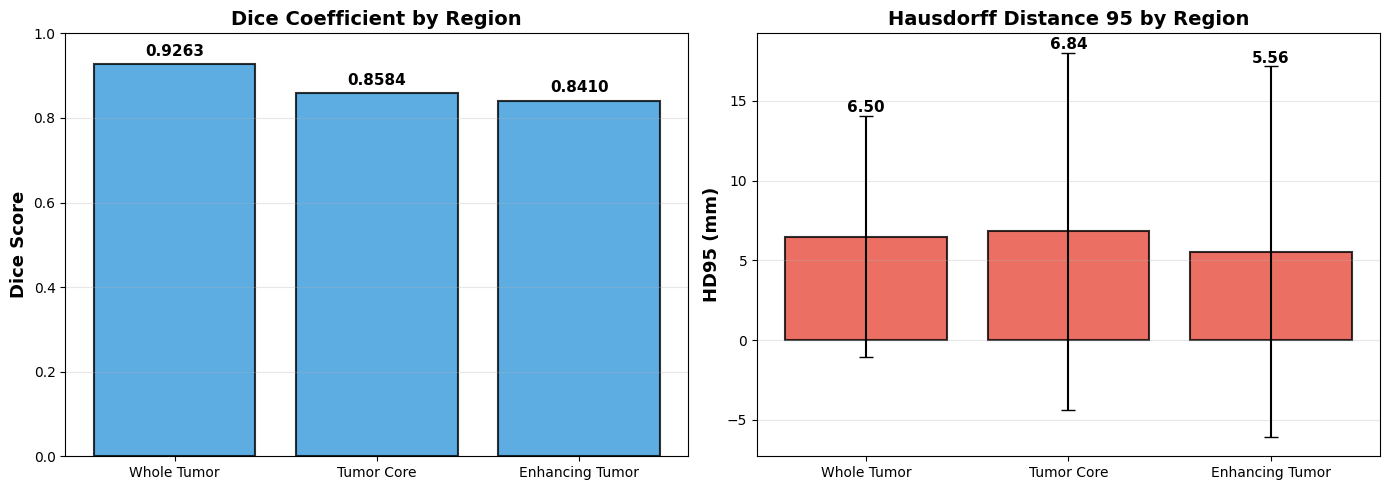

✓ Visualization saved as 'evaluation_results.png'

                         EVALUATION COMPLETE!


In [13]:
# ============================================================================
# 8. COMPREHENSIVE EVALUATION: DICE SCORE & HAUSDORFF DISTANCE
# ============================================================================

import numpy as np
import pandas as pd
from scipy.ndimage import distance_transform_edt, binary_erosion
import matplotlib.pyplot as plt

print("="*80)
print(" " * 20 + "MODEL EVALUATION - BRATS 2021")
print("="*80)

# --- Load Best Model ---
print("\n[1/4] Loading best trained model...")
test_gen = BraTSDataGenerator(test, patch_size=PATCH_SIZE, batch_size=1, augment=False, shuffle=False)

best_model = keras.models.load_model(
    str(SAVE_DIR / '3d_unet_model_new.keras'),
    custom_objects={
        'combined_dice_ce_loss': combined_dice_ce_loss,
        'dice_whole_tumor': dice_whole_tumor,
        'dice_tumor_core': dice_tumor_core,
        'dice_enhancing_tumor': dice_enhancing_tumor,
        'iou_coef': iou_coef
    }
)
print("✓ Model loaded successfully!")

# --- Evaluate Dice Scores ---
print("\n[2/4] Computing Dice scores on test set...")
scores = best_model.evaluate(test_gen, verbose=0)
print(f"✓ Dice evaluation complete!")

dice_results = {
    'Whole Tumor': scores[1],
    'Tumor Core': scores[2],
    'Enhancing Tumor': scores[3]
}

# --- Compute Hausdorff Distances on Full Volumes ---
print("\n[3/4] Computing Hausdorff distances (HD95) on full test volumes...")
print("    (This may take a few minutes...)")

hd_whole_tumor = []
hd_tumor_core = []
hd_enhancing_tumor = []

num_samples_hd = len(test)  # Use ALL test samples

for i in range(num_samples_hd):
    try:
        patient_id = test.iloc[i]['patient_id']
        
        # Load full volume
        full_image = np.load(test.iloc[i]['image_path'])
        full_mask_gt = np.load(test.iloc[i]['mask_path'])
        
        h, w, d, c = full_image.shape
        
        # Create output mask for prediction
        pred_mask_full = np.zeros((h, w, d, 4), dtype=np.float32)
        pred_count = np.zeros((h, w, d, 1), dtype=np.float32)
        
        # Sliding window prediction
        patch_size = PATCH_SIZE[0]
        stride = patch_size // 2
        
        for z in range(0, max(1, d - patch_size + 1), stride):
            for y in range(0, max(1, h - patch_size + 1), stride):
                for x in range(0, max(1, w - patch_size + 1), stride):
                    z_end = min(z + patch_size, d)
                    y_end = min(y + patch_size, h)
                    x_end = min(x + patch_size, w)
                    
                    z_start = max(0, z_end - patch_size)
                    y_start = max(0, y_end - patch_size)
                    x_start = max(0, x_end - patch_size)
                    
                    patch = full_image[y_start:y_end, x_start:x_end, z_start:z_end, :]
                    
                    if patch.shape[:3] != (patch_size, patch_size, patch_size):
                        padded = np.zeros((patch_size, patch_size, patch_size, 4), dtype=np.float32)
                        padded[:patch.shape[0], :patch.shape[1], :patch.shape[2], :] = patch
                        patch = padded
                    
                    pred_patch = best_model.predict(np.expand_dims(patch, axis=0), verbose=0)[0]
                    
                    actual_h = min(patch_size, y_end - y_start)
                    actual_w = min(patch_size, x_end - x_start)
                    actual_d = min(patch_size, z_end - z_start)
                    
                    pred_mask_full[y_start:y_end, x_start:x_end, z_start:z_end, :] += pred_patch[:actual_h, :actual_w, :actual_d, :]
                    pred_count[y_start:y_end, x_start:x_end, z_start:z_end, :] += 1
        
        pred_count = np.maximum(pred_count, 1)
        pred_mask_full = pred_mask_full / pred_count
        pred_labels = np.argmax(pred_mask_full, axis=-1)
        
        # Compute HD95
        hd_results = compute_hausdorff_for_sample(full_mask_gt, pred_labels, spacing=(1.0, 1.0, 1.0))
        
        if np.isfinite(hd_results['whole_tumor']) and hd_results['whole_tumor'] > 0:
            hd_whole_tumor.append(hd_results['whole_tumor'])
        if np.isfinite(hd_results['tumor_core']) and hd_results['tumor_core'] > 0:
            hd_tumor_core.append(hd_results['tumor_core'])
        if np.isfinite(hd_results['enhancing_tumor']) and hd_results['enhancing_tumor'] > 0:
            hd_enhancing_tumor.append(hd_results['enhancing_tumor'])
        
        if (i + 1) % 5 == 0:
            print(f"    ✓ Processed {i+1}/{num_samples_hd} samples")
        
    except Exception as e:
        print(f"    ✗ Error on sample {i+1}: {str(e)[:50]}")

print("✓ Hausdorff distance computation complete!")

# --- Compile Results ---
print("\n[4/4] Compiling results...")

hd_results = {
    'Whole Tumor': (np.mean(hd_whole_tumor), np.std(hd_whole_tumor), len(hd_whole_tumor)) if len(hd_whole_tumor) > 0 else (np.nan, np.nan, 0),
    'Tumor Core': (np.mean(hd_tumor_core), np.std(hd_tumor_core), len(hd_tumor_core)) if len(hd_tumor_core) > 0 else (np.nan, np.nan, 0),
    'Enhancing Tumor': (np.mean(hd_enhancing_tumor), np.std(hd_enhancing_tumor), len(hd_enhancing_tumor)) if len(hd_enhancing_tumor) > 0 else (np.nan, np.nan, 0)
}

# ============================================================================
# RESULTS DISPLAY
# ============================================================================

print("\n" + "="*80)
print(" " * 25 + "EVALUATION RESULTS")
print("="*80)

# --- Dice Scores Table ---
print("\n┌───────────────────────────────────────────────────────┐")
print("│              DICE COEFFICIENT (DSC)                   │")
print("├───────────────────────────────────────────────────────┤")
print("│  Region                │  Score      │  Percentage    │")
print("├────────────────────────┼─────────────┼────────────────┤")

for region, score in dice_results.items():
    percentage = score * 100
    print(f"│  {region:<20}  │   {score:.4f}    │    {percentage:5.2f}%      │")

print("└────────────────────────┴─────────────┴────────────────┘")

# --- Hausdorff Distance Table ---
print("\n┌─────────────────────────────────────────────────────────────────┐")
print("│        HAUSDORFF DISTANCE 95th PERCENTILE (HD95)               │")
print("├─────────────────────────────────────────────────────────────────┤")
print("│  Region                │  Mean (mm)  │  Std (mm)  │  Samples  │")
print("├────────────────────────┼─────────────┼────────────┼───────────┤")

for region, (mean_hd, std_hd, n_samples) in hd_results.items():
    if not np.isnan(mean_hd):
        print(f"│  {region:<20}  │    {mean_hd:6.2f}   │   {std_hd:5.2f}   │    {n_samples:3d}    │")
    else:
        print(f"│  {region:<20}  │      N/A     │     N/A    │    {n_samples:3d}    │")

print("└────────────────────────┴─────────────┴────────────┴───────────┘")

# --- Summary Table ---
print("\n" + "="*80)
print(" " * 28 + "SUMMARY TABLE")
print("="*80)

summary_df = pd.DataFrame({
    'Metric': ['Dice Score', 'Hausdorff Distance 95 (mm)'],
    'Whole Tumor': [
        f"{dice_results['Whole Tumor']:.4f}",
        f"{hd_results['Whole Tumor'][0]:.2f}" if not np.isnan(hd_results['Whole Tumor'][0]) else "N/A"
    ],
    'Tumor Core': [
        f"{dice_results['Tumor Core']:.4f}",
        f"{hd_results['Tumor Core'][0]:.2f}" if not np.isnan(hd_results['Tumor Core'][0]) else "N/A"
    ],
    'Enhancing Tumor': [
        f"{dice_results['Enhancing Tumor']:.4f}",
        f"{hd_results['Enhancing Tumor'][0]:.2f}" if not np.isnan(hd_results['Enhancing Tumor'][0]) else "N/A"
    ]
})

print(summary_df.to_string(index=False))

# --- Visualization ---
print("\n[BONUS] Creating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Dice Scores
regions = list(dice_results.keys())
dice_values = list(dice_results.values())

axes[0].bar(regions, dice_values, color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Dice Score', fontsize=13, fontweight='bold')
axes[0].set_title('Dice Coefficient by Region', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(dice_values):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

# Plot 2: Hausdorff Distance
hd_means = [hd_results[r][0] for r in regions]
hd_stds = [hd_results[r][1] for r in regions]

axes[1].bar(regions, hd_means, yerr=hd_stds, color='#e74c3c', alpha=0.8, 
            edgecolor='black', linewidth=1.5, capsize=5)
axes[1].set_ylabel('HD95 (mm)', fontsize=13, fontweight='bold')
axes[1].set_title('Hausdorff Distance 95 by Region', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, (m, s) in enumerate(zip(hd_means, hd_stds)):
    if not np.isnan(m):
        axes[1].text(i, m + s + 0.2, f'{m:.2f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'evaluation_results.png'")

print("\n" + "="*80)
print(" " * 25 + "EVALUATION COMPLETE!")
print("="*80)

## 9. Visualization (Optional)
Visualization utilities to inspect predictions visually can be added here.

3D VOLUME RENDERING VISUALIZATION

--- Visualizing Sample 1/3 ---
Rendering Ground Truth for sample 1...


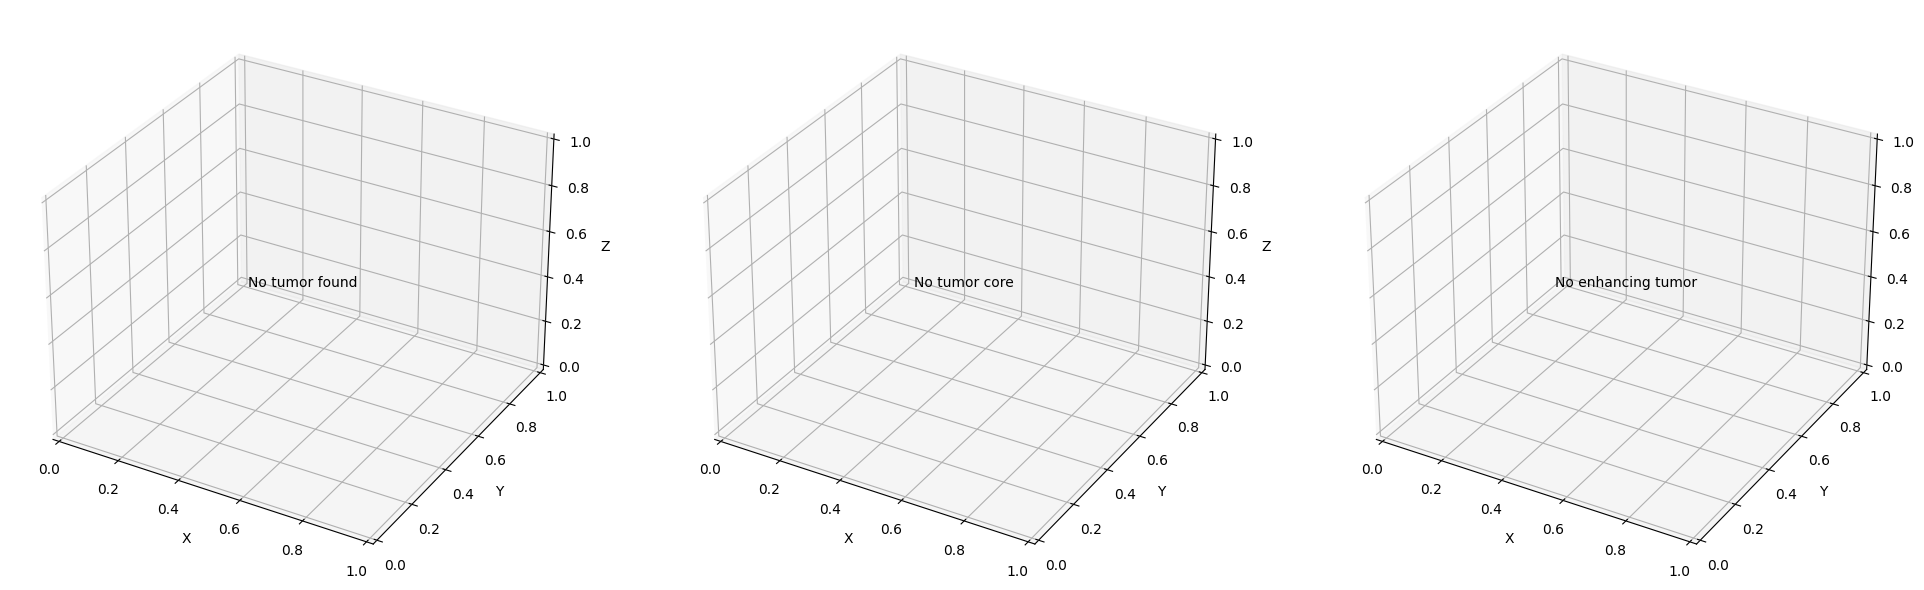

Rendering Prediction for sample 1...


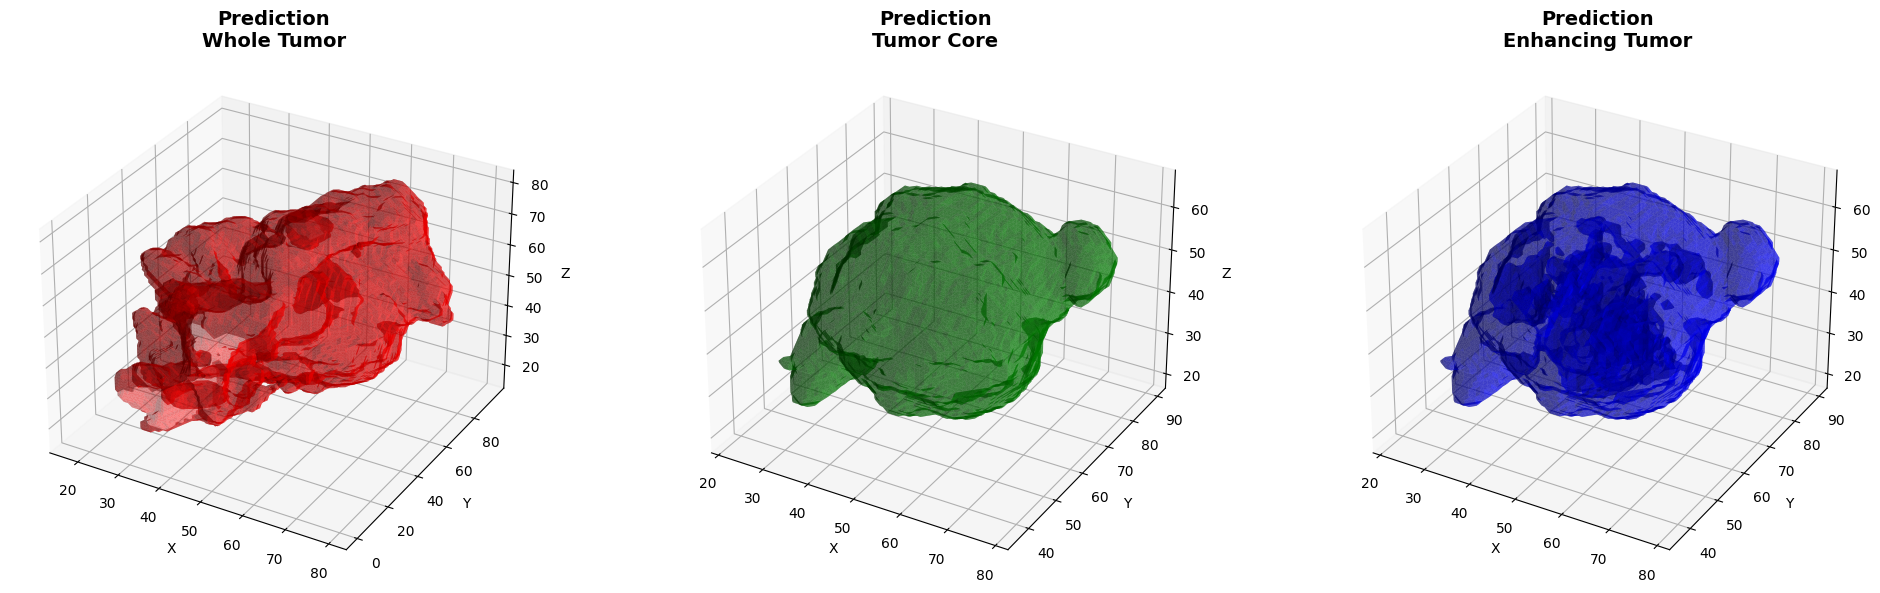

✓ Sample 1 visualization complete!


--- Visualizing Sample 2/3 ---
Rendering Ground Truth for sample 2...


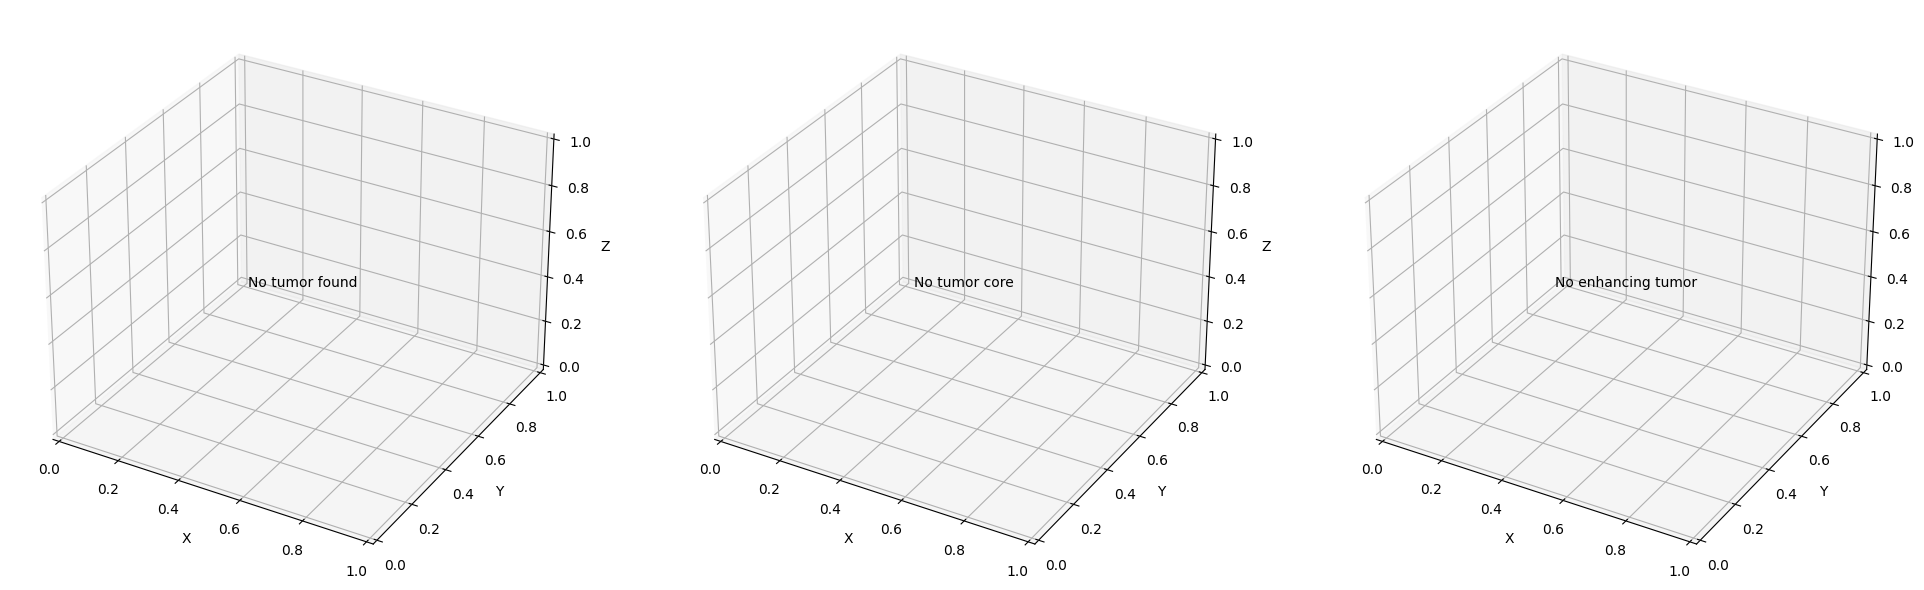

Rendering Prediction for sample 2...


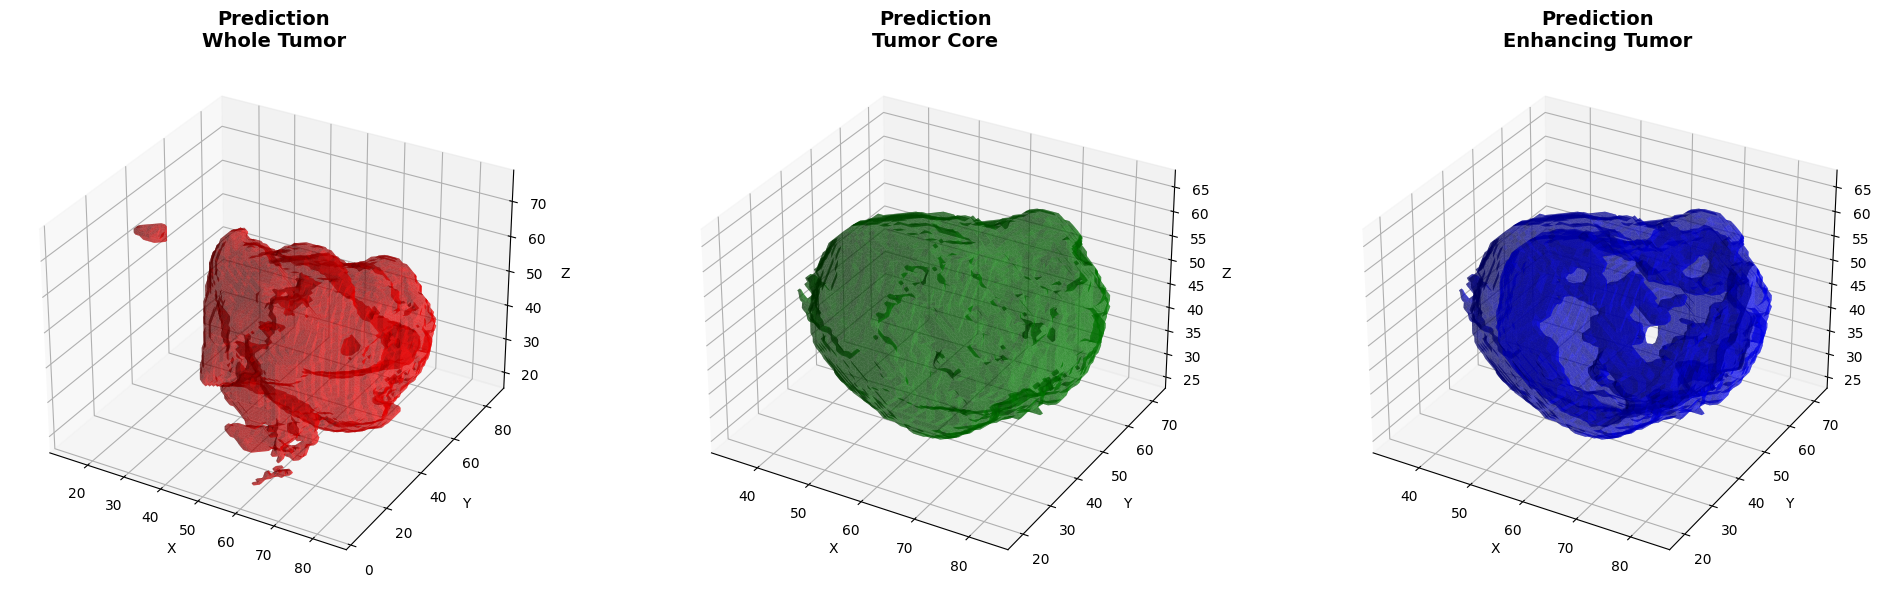

✓ Sample 2 visualization complete!


--- Visualizing Sample 3/3 ---
Rendering Ground Truth for sample 3...


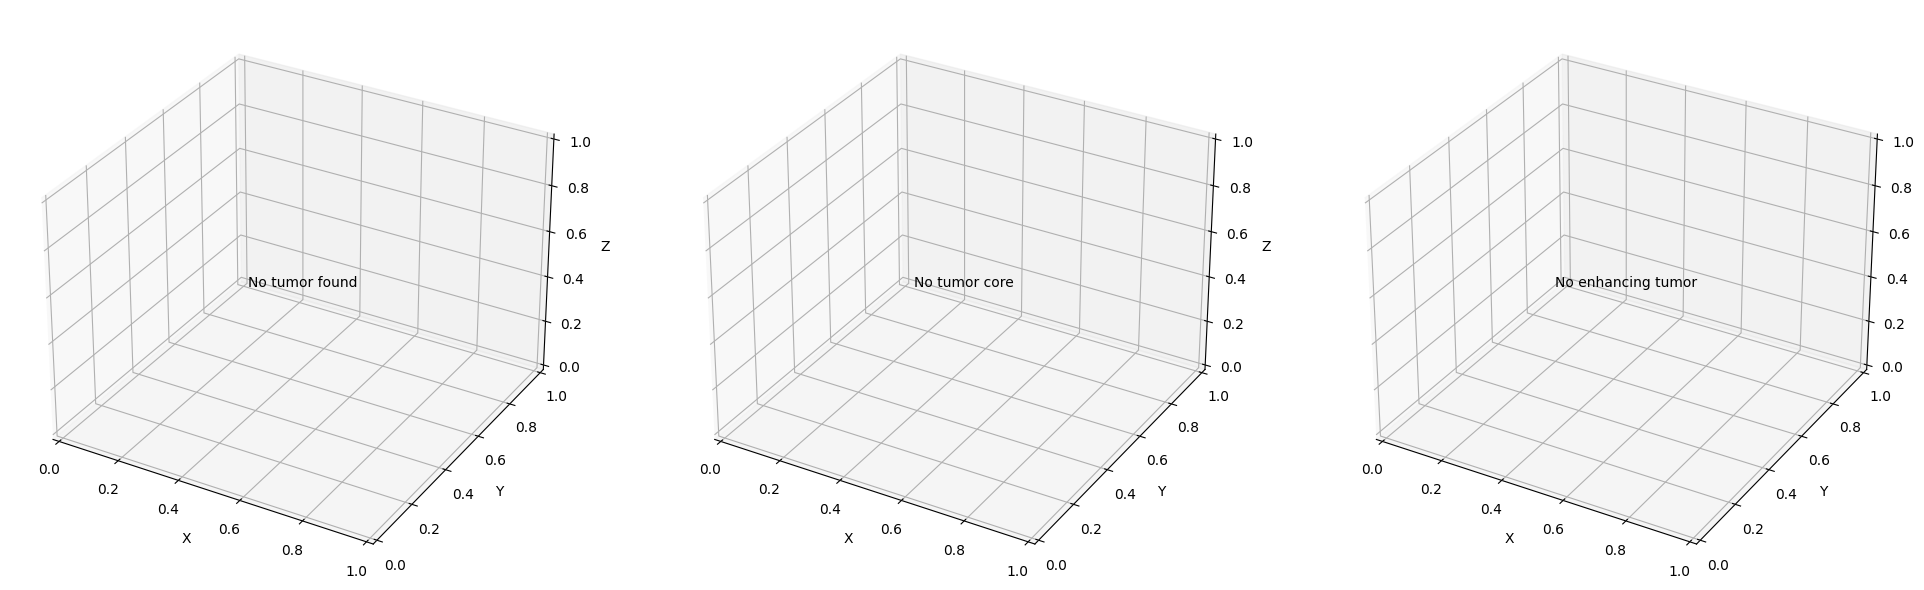

Rendering Prediction for sample 3...


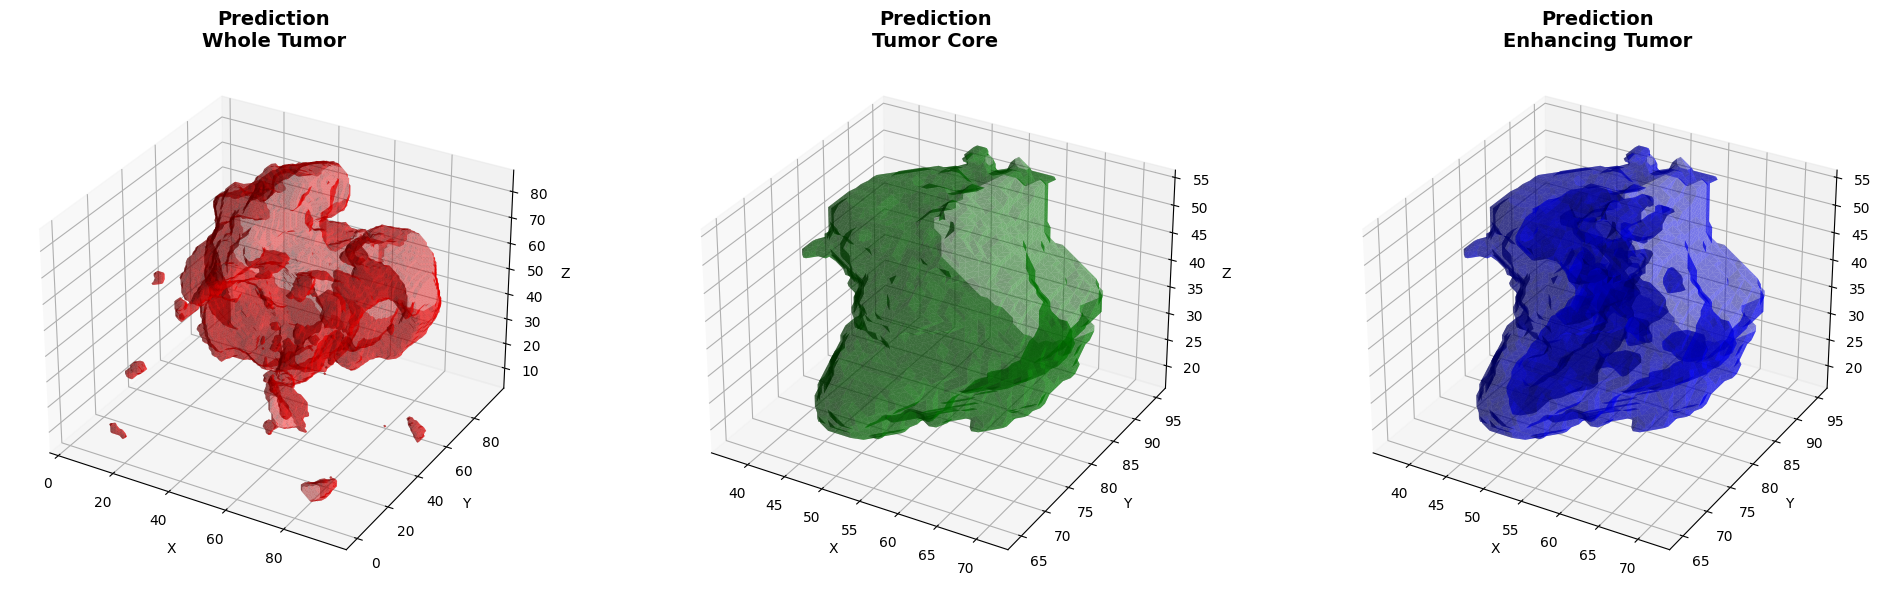

✓ Sample 3 visualization complete!

3D VISUALIZATION COMPLETE!


In [14]:
# 9. 3D Volume Rendering Visualization

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import numpy as np

def render_3d_volume(volume, threshold=0.5, title="3D Volume", color='red', alpha=0.3):
    """
    Render a 3D volume using marching cubes algorithm
    
    Args:
        volume: 3D numpy array (binary or probability mask)
        threshold: Threshold for creating isosurface
        title: Plot title
        color: Surface color
        alpha: Transparency
    """
    # Ensure binary volume
    volume_binary = (volume > threshold).astype(np.uint8)
    
    if np.sum(volume_binary) == 0:
        print(f"Warning: Empty volume for {title}")
        return None
    
    # Use marching cubes to create surface mesh
    try:
        verts, faces, normals, values = measure.marching_cubes(volume_binary, level=0.5)
    except:
        print(f"Could not generate mesh for {title}")
        return None
    
    # Create 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           color=color, alpha=alpha, linewidth=0.2, 
                           antialiased=True, shade=True)
    
    ax.set_xlabel('X axis', fontsize=12)
    ax.set_ylabel('Y axis', fontsize=12)
    ax.set_zlabel('Z axis', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Set equal aspect ratio
    max_range = np.array([verts[:, 0].max()-verts[:, 0].min(), 
                          verts[:, 1].max()-verts[:, 1].min(), 
                          verts[:, 2].max()-verts[:, 2].min()]).max() / 2.0
    
    mid_x = (verts[:, 0].max()+verts[:, 0].min()) * 0.5
    mid_y = (verts[:, 1].max()+verts[:, 1].min()) * 0.5
    mid_z = (verts[:, 2].max()+verts[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    return fig


def plot_3d_tumor_regions(mask_3d, title_prefix=""):
    """
    Plot 3D rendering of different tumor regions with different colors
    
    Args:
        mask_3d: 3D mask array (H, W, D) with class labels or (H, W, D, C) one-hot
        title_prefix: Prefix for plot titles (e.g., "Ground Truth" or "Prediction")
    """
    # Convert one-hot to labels if needed
    if len(mask_3d.shape) == 4:
        labels_3d = np.argmax(mask_3d, axis=-1)
    else:
        labels_3d = mask_3d
    
    # Create masks for different tumor regions
    whole_tumor = (labels_3d > 0).astype(np.uint8)
    tumor_core = np.isin(labels_3d, [1, 3]).astype(np.uint8)
    enhancing_tumor = (labels_3d == 3).astype(np.uint8)
    
    fig = plt.figure(figsize=(20, 6))
    
    # Whole Tumor (red)
    ax1 = fig.add_subplot(131, projection='3d')
    if np.sum(whole_tumor) > 100:  # Need enough voxels for rendering
        try:
            verts, faces, _, _ = measure.marching_cubes(whole_tumor, level=0.5)
            ax1.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           color='red', alpha=0.5, linewidth=0, antialiased=True)
            ax1.set_title(f'{title_prefix}\nWhole Tumor', fontsize=14, fontweight='bold')
        except:
            ax1.text(0.5, 0.5, 0.5, 'Cannot render', ha='center')
    else:
        ax1.text(0.5, 0.5, 0.5, 'No tumor found', ha='center')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Tumor Core (green)
    ax2 = fig.add_subplot(132, projection='3d')
    if np.sum(tumor_core) > 100:
        try:
            verts, faces, _, _ = measure.marching_cubes(tumor_core, level=0.5)
            ax2.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           color='green', alpha=0.5, linewidth=0, antialiased=True)
            ax2.set_title(f'{title_prefix}\nTumor Core', fontsize=14, fontweight='bold')
        except:
            ax2.text(0.5, 0.5, 0.5, 'Cannot render', ha='center')
    else:
        ax2.text(0.5, 0.5, 0.5, 'No tumor core', ha='center')
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Enhancing Tumor (blue)
    ax3 = fig.add_subplot(133, projection='3d')
    if np.sum(enhancing_tumor) > 100:
        try:
            verts, faces, _, _ = measure.marching_cubes(enhancing_tumor, level=0.5)
            ax3.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           color='blue', alpha=0.5, linewidth=0, antialiased=True)
            ax3.set_title(f'{title_prefix}\nEnhancing Tumor', fontsize=14, fontweight='bold')
        except:
            ax3.text(0.5, 0.5, 0.5, 'Cannot render', ha='center')
    else:
        ax3.text(0.5, 0.5, 0.5, 'No enhancing tumor', ha='center')
    
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    
    plt.tight_layout()
    return fig


# ============================================
# ACTUAL FUNCTION CALLS - Visualize samples
# ============================================

print("=" * 60)
print("3D VOLUME RENDERING VISUALIZATION")
print("=" * 60)

# Select a few test samples for visualization
num_viz_samples = 3  # Visualize 3 samples

for idx in range(min(num_viz_samples, len(test))):
    print(f"\n--- Visualizing Sample {idx+1}/{num_viz_samples} ---")
    
    # Get sample
    sample_image, sample_mask = test_gen[idx]
    
    # Get prediction
    pred_mask = best_model.predict(sample_image, verbose=0)
    
    # Ground Truth 3D Rendering
    print(f"Rendering Ground Truth for sample {idx+1}...")
    fig_gt = plot_3d_tumor_regions(sample_mask[0], title_prefix="Ground Truth")
    plt.savefig(f'3d_ground_truth_sample_{idx+1}.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Prediction 3D Rendering
    print(f"Rendering Prediction for sample {idx+1}...")
    fig_pred = plot_3d_tumor_regions(pred_mask[0], title_prefix="Prediction")
    plt.savefig(f'3d_prediction_sample_{idx+1}.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Sample {idx+1} visualization complete!\n")

print("=" * 60)
print("3D VISUALIZATION COMPLETE!")
print("=" * 60)

In [ ]:
import matplotlib.pyplot as plt
def plot_segmentation_results(image, true_mask, pred_mask, slice_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:,:,slice_idx,0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(true_mask[:,:,slice_idx], cmap='jet', alpha=0.5)
    axes[1].set_title('True Mask')
    axes[2].imshow(pred_mask[:,:,slice_idx], cmap='jet', alpha=0.5)
    axes[2].set_title('Predicted Mask')
    plt.show()

# Example of how to use it after evaluation
for i in range(2):
    sample_image, sample_true_mask = test_gen[i]
    sample_pred_mask = best_model.predict(sample_image)
    plot_segmentation_results(sample_image[0], sample_true_mask[0], np.argmax(sample_pred_mask[0], axis=-1), slice_idx=sample_image.shape[1] // 2)
